In [1]:
import csv
import glob
import pickle
import numpy as np
import scipy as sp
from scipy.stats import ttest_ind
import seaborn as sns; sns.set()
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
metrics_selected = list(['death','cuminfection_0','cuminfection_1', 'cuminfection_2', 'cuminfection_12', 
                         'cuminfection_X', 'labresult_0', 'labresult_1', 'labresult_2', 'labresult_12',
                        'cumsuperinfection', 'colonization_0', 'colonization_1', 'colonization_2', 
                         'colonization_12', 'misempiric', 'tempempiric', 'def_drug_use_A', 'def_drug_use_B', 
                         'def_drug_use_C', 'def_drug_use_L', 'corr_drug_use_A', 'corr_drug_use_B', 
                         'corr_drug_use_C', 'corr_drug_use_L', 'mutation_1', 'mutation_2', 'mutation_12', 
                         'transmission_0', 'transmission_1', 'transmission_2', 'transmission_12'])

metrics2_selected = list(['realcuminfection_0','realcuminfection_1','realcuminfection_2','realcuminfection_12',
                         'misempirictotal','druguseB','druguseC', 'cuminfection'])

In [3]:
NN = 32.

In [4]:
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def cohen_d_compute(v1, v2, metric):
    v1_metric_list = [value[metric][-1]/value['admission'][-1]*100 for key, value in v1.items()]
    v2_metric_list = [value[metric][-1]/value['admission'][-1]*100 for key, value in v2.items()]
    return round(cohen_d(v1_metric_list, v2_metric_list),3)

def cohen_d_compute_time(v1, v2, metric, n):
    v1_metric_list = [value[metric][n]/(NN+value['admission'][n])*100 for key, value in v1.items()]
    v2_metric_list = [value[metric][n]/(NN+value['admission'][n])*100 for key, value in v2.items()]
    return round(cohen_d(v1_metric_list, v2_metric_list),3)

def cohen_d_compute_iter(v1, v2, metric, n):
    v1_metric_list = [value[metric][-1]/(NN+value['admission'][-1])*100 for key, value in v1.items()]
    v2_metric_list = [value[metric][-1]/(NN+value['admission'][-1])*100 for key, value in v2.items()]
    return round(cohen_d(v1_metric_list[:n], v2_metric_list[:n]),3)

In [5]:
def cohen_d_metrics2 (v1, v2, n, metric):
    if metric == 'realcuminfection_0':
        v1_metric_list = [(value['labresult_0'][n]+value['transmission_0'][n])/(NN+value['admission'][n])*100 for key, value in v1.items()]
        v2_metric_list = [(value['labresult_0'][n]+value['transmission_0'][n])/(NN+value['admission'][n])*100 for key, value in v2.items()]
    elif metric == 'realcuminfection_1':
        v1_metric_list = [(value['labresult_1'][n]+value['transmission_1'][n]+value['mutation_1'][n])/(NN+value['admission'][n])*100 for key, value in v1.items()]
        v2_metric_list = [(value['labresult_1'][n]+value['transmission_1'][n]+value['mutation_1'][n])/(NN+value['admission'][n])*100 for key, value in v2.items()]
    elif metric == 'realcuminfection_2':
        v1_metric_list = [(value['labresult_2'][n]+value['transmission_2'][n]+value['mutation_2'][n])/(NN+value['admission'][n])*100 for key, value in v1.items()]
        v2_metric_list = [(value['labresult_2'][n]+value['transmission_2'][n]+value['mutation_2'][n])/(NN+value['admission'][n])*100 for key, value in v2.items()]
    elif metric == 'realcuminfection_12':
        v1_metric_list = [(value['labresult_12'][n]+value['transmission_12'][n]+value['mutation_12'][n])/(NN+value['admission'][n])*100 for key, value in v1.items()]
        v2_metric_list = [(value['labresult_12'][n]+value['transmission_12'][n]+value['mutation_12'][n])/(NN+value['admission'][n])*100 for key, value in v2.items()]
    elif metric == 'misempirictotal':
        v1_metric_list = [(value['misempiric'][n]+value['labresult_2'][n]+value['labresult_12'][n])/(NN+value['admission'][n])*100 for key, value in v1.items()]
        v2_metric_list = [(value['misempiric'][n]+value['labresult_2'][n]+value['labresult_12'][n])/(NN+value['admission'][n])*100 for key, value in v2.items()]
    elif metric == 'druguseB':
        v1_metric_list = [(value['def_drug_use_B'][n]+value['corr_drug_use_B'][n])/(NN+value['admission'][n])*100 for key, value in v1.items()]
        v2_metric_list = [(value['def_drug_use_B'][n]+value['corr_drug_use_B'][n])/(NN+value['admission'][n])*100 for key, value in v2.items()]
    elif metric == 'druguseC':
        v1_metric_list = [(value['def_drug_use_C'][n]+value['corr_drug_use_C'][n])/(NN+value['admission'][n])*100 for key, value in v1.items()]
        v2_metric_list = [(value['def_drug_use_C'][n]+value['corr_drug_use_C'][n])/(NN+value['admission'][n])*100 for key, value in v2.items()]
    elif metric == 'cuminfection':
        v1_metric_list = [(value['labresult_0'][n]+value['transmission_0'][n]+value['labresult_1'][n]+value['transmission_1'][n]+value['mutation_1'][n]
                          +value['labresult_2'][n]+value['transmission_2'][n]+value['mutation_2'][n]+value['labresult_12'][n]+value['transmission_12'][n]+value['mutation_12'][n])/(NN+value['admission'][n])*100 for key, value in v1.items()]
        v2_metric_list = [(value['labresult_0'][n]+value['transmission_0'][n]+value['labresult_1'][n]+value['transmission_1'][n]+value['mutation_1'][n]
                          +value['labresult_2'][n]+value['transmission_2'][n]+value['mutation_2'][n]+value['labresult_12'][n]+value['transmission_12'][n]+value['mutation_12'][n])/(NN+value['admission'][n])*100 for key, value in v2.items()]
    return round(cohen_d(v1_metric_list, v2_metric_list),3)

In [6]:
folder_path = "/Users/xxh31/Desktop/rand_expmts/p32h8/"

file_names = ['q=0.3_p&r=0.3', 'q=0.2_p&r=0.5', 'q=0.5_p&r=0.2', 'q=0.15_p&r=0.15', 
              'q=0.05_p&r=0.5', 'q=0.5_p&r=0.05']

dic_metrics1 = {}

for file_name in file_names:
    pairs = ('v1_' + file_name, 'v2_' + file_name)
    
    pkl_file1 = glob.glob(folder_path+pairs[0]+'/*.pkl')[0]
    
    with open(pkl_file1, "rb") as f:
        record_v1 = pickle.load(f) 
        
    pkl_file2 = glob.glob(folder_path+pairs[1]+'/*.pkl')[0]
    
    with open(pkl_file2, "rb") as f:
        record_v2 = pickle.load(f)
    
    longlist = []
    for metric in metrics_selected:
        clist = []
        for i in range (1,209):
            clist.append(cohen_d_compute_time(record_v2, record_v1, metric, 7*i)) #swap on purpose!
        longlist.append(clist)
    
    dic_metrics1[file_name]=longlist

<ipython-input-4-ec9ce322caba>:5: RuntimeWarning: invalid value encountered in double_scalars
  return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)


In [3]:
#import pickle
#with open('metrics1_p64h16.pickle', 'wb') as handle:
#    pickle.dump(dic_metrics1, handle, protocol=pickle.HIGHEST_PROTOCOL)
import pickle
with open('metrics1_p64h16.pickle', 'rb') as handle:
    dic_metrics1 = pickle.load(handle)

In [7]:
folder_path = "/Users/xxh31/Desktop/rand_expmts/p32h8/"

file_names = ['q=0.3_p&r=0.3', 'q=0.2_p&r=0.5', 'q=0.5_p&r=0.2', 'q=0.15_p&r=0.15', 
              'q=0.05_p&r=0.5', 'q=0.5_p&r=0.05']

dic_metrics2 = {}

for file_name in file_names:
    pairs = ('v1_' + file_name, 'v2_' + file_name)
    
    pkl_file1 = glob.glob(folder_path+pairs[0]+'/*.pkl')[0]
    
    with open(pkl_file1, "rb") as f:
        record_v1 = pickle.load(f)
        
    pkl_file2 = glob.glob(folder_path+pairs[1]+'/*.pkl')[0]
    
    with open(pkl_file2, "rb") as f:
        record_v2 = pickle.load(f)
    
    longlist = []
    for metric in metrics2_selected:
        clist = []
        for i in range (1,209):
            clist.append(cohen_d_metrics2(record_v2, record_v1, 7*i, metric)) # swap on purpose!
        longlist.append(clist)
    
    dic_metrics2[file_name]=longlist

In [107]:
#with open('metrics2_p64h16.pickle', 'wb') as handle:
#    pickle.dump(dic_metrics2, handle, protocol=pickle.HIGHEST_PROTOCOL)
import pickle
with open('metrics2_p16h4.pickle', 'rb') as handle:
    dic_metrics2 = pickle.load(handle)

In [8]:
file_name = 'q=0.3_p&r=0.3'

time_week = ['6 mos.', '12 mos.', '18 mos.', '24 mos.', '30 mos.', '36 mos.', '42 mos.', '48 mos.']
df = pd.DataFrame({'time': time_week, 
                   'Cum Infec str0': dic_metrics2[file_name][0][25::26], 
                   'Cum Infec str1': dic_metrics2[file_name][1][25::26],
                   'Cum Infec str2': dic_metrics2[file_name][2][25::26],
                   'Cum Infec str12': dic_metrics2[file_name][3][25::26],
                   'Cum Infec': dic_metrics2[file_name][7][25::26],
                   'Mis Empiric': dic_metrics2[file_name][4][25::26],
                   #'Drug Use B': dic_metrics2[file_name][5][25::26],
                   'Drug Use C': dic_metrics2[file_name][6][25::26]
                  })

dff =  pd.melt(df, id_vars="time", var_name=" ", value_name="Cohen's D")

In [141]:
df1 = pd.DataFrame({'time': time_week, 
                   'Cum Col str0': dic_metrics1[file_name][11][25::26],
                   'Cum Col str1': dic_metrics1[file_name][12][25::26],
                   'Cum Col str2': dic_metrics1[file_name][13][25::26],
                   'Cum Col str12': dic_metrics1[file_name][14][25::26],
                   'Deaths': dic_metrics1[file_name][0][25::26],
                   #'Mut str1': dic_metrics1[file_name][25][25::26],
                   'Mut str2': dic_metrics1[file_name][26][25::26],
                   'Cum Sup Infec': dic_metrics1[file_name][10][25::26]
                  })

dff1 =  pd.melt(df1, id_vars="time", var_name=" ", value_name="Cohen's D")

In [142]:
time_week = ['6 mos.', '12 mos.', '18 mos.', '24 mos.', '30 mos.', '36 mos.', '42 mos.', '48 mos.']
df2 = pd.DataFrame({'time': time_week, 
                   'Mut str1': dic_metrics1[file_name][25][25::26],
                   #'Cum Sup Infec': dic_metrics1[file_name][10][25::26],
                    'Drug Use B': dic_metrics2[file_name][5][25::26]
                  })

dff2 =  pd.melt(df2, id_vars="time", var_name=" ", value_name="Cohen's D")

In [14]:
file_name = 'q=0.5_p&r=0.05'

time_week = ['6 mos.', '12 mos.', '18 mos.', '24 mos.', '30 mos.', '36 mos.', '42 mos.', '48 mos.']
df3 = pd.DataFrame({'time': time_week, 
                   'Lab Result str0': dic_metrics1[file_name][6][25::26],
                   'Lab Result str1': dic_metrics1[file_name][7][25::26],
                   'Lab Result str2': dic_metrics1[file_name][8][25::26],
                   'Lab Result str12': dic_metrics1[file_name][9][25::26],
                   'Mut str12': dic_metrics1[file_name][27][25::26]
                  })

dff3 =  pd.melt(df3, id_vars="time", var_name=" ", value_name="Cohen's D")

<Figure size 360x1080 with 0 Axes>

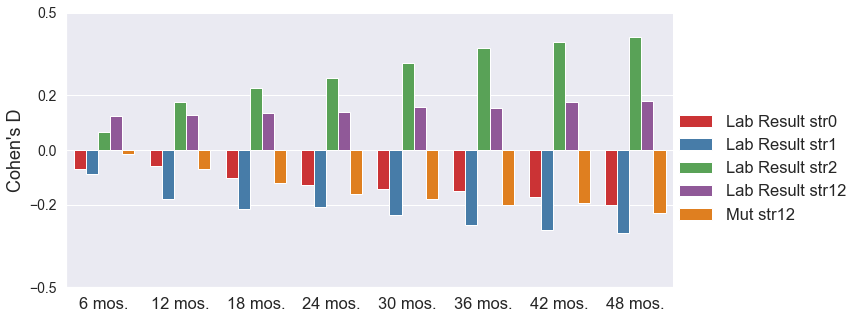

In [15]:
fig=plt.figure(figsize=(5,15))
sns.set(font_scale = 1.5)
ax = sns.catplot(x='time', y="Cohen's D", hue=' ', data=dff3, kind='bar', height=5, aspect=2., palette = 'Set1')
plt.yticks([-0.5,-0.2,0,0.2,0.5], fontsize=14)
ax.set(xlabel=None)
plt.xticks(rotation=0)
plt.savefig('barplot_metric4_p64h16_q50pr5.pdf', dpi = 300, bbox_inches = "tight")
plt.show()

<Figure size 360x1080 with 0 Axes>

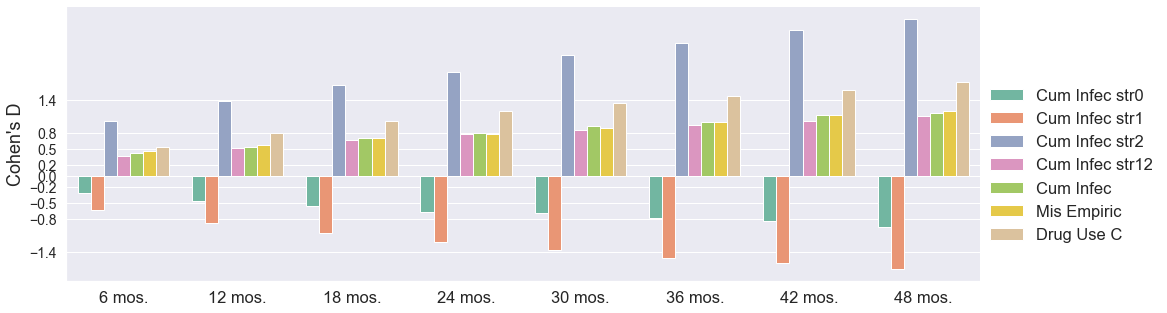

In [9]:
fig=plt.figure(figsize=(5,15))
sns.set(font_scale = 1.5)
ax = sns.catplot(x='time', y="Cohen's D", hue=' ', data=dff, kind='bar', height=5, aspect=2.8, palette = "Set2")
#plt.axhline(0.2, ls='dotted')
#plt.axhline(0.5, ls='dotted')
#plt.axhline(0.8, ls='dotted')
#plt.axhline(1.4, ls='dotted')
#plt.axhline(-0.2, ls='dotted')
#plt.axhline(-.5, ls='dotted')
#plt.axhline(-0.8, ls='dotted')
plt.yticks([-1.4,-0.8,-0.5,-0.2,0,0.2,0.5,0.8,1.4], fontsize = 14)
ax.set(xlabel=None)

#plt.savefig('barplot_metric1_p16h4_q50pr5.pdf', dpi = 300, bbox_inches = "tight")

plt.show()

<Figure size 360x1080 with 0 Axes>

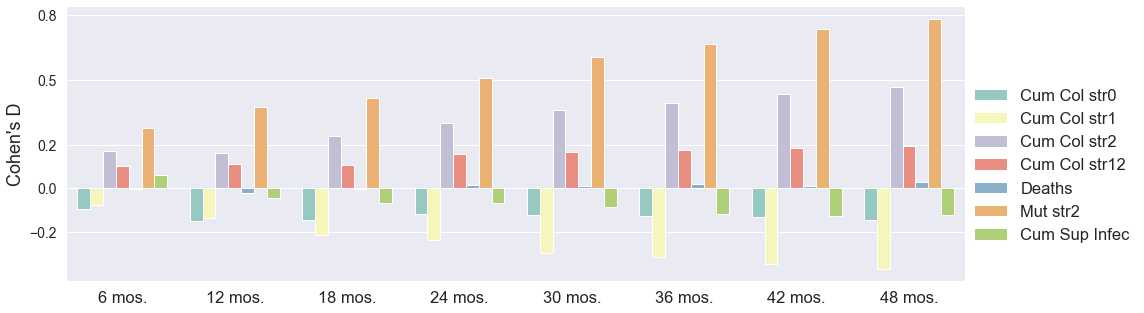

In [147]:
fig=plt.figure(figsize=(5,15))
sns.set(font_scale = 1.5)
ax = sns.catplot(x='time', y="Cohen's D", hue=' ', data=dff1, kind='bar', height=5, aspect=2.8, palette = 'Set3')
#plt.axhline(0.2, ls='dotted')
#plt.axhline(0.5, ls='dotted')
#plt.axhline(0.8, ls='dotted')
#plt.axhline(-0.2, ls='dotted')
#plt.axhline(-0.5, ls='dotted')
plt.yticks([-0.2,0,0.2,0.5,0.8], fontsize=14)
ax.set(xlabel=None)
plt.savefig('barplot_metric2_p16h4_q50pr5.pdf', dpi = 300, bbox_inches = "tight")
plt.show()

<Figure size 360x1080 with 0 Axes>

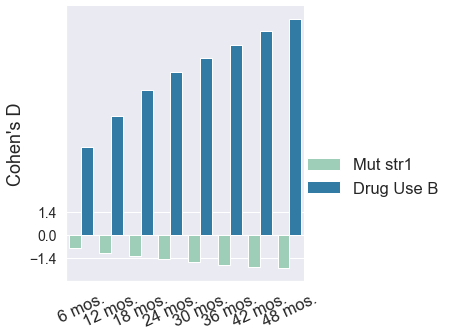

In [148]:
fig=plt.figure(figsize=(5,15))
sns.set(font_scale = 1.5)
ax = sns.catplot(x='time', y="Cohen's D", hue=' ', data=dff2, kind='bar', height=5, aspect=1., palette = 'YlGnBu')
plt.yticks([-1.4,0,1.4], fontsize=14)
ax.set(xlabel=None)
plt.xticks(rotation=25)
plt.savefig('barplot_metric3_p16h4_q50pr5.pdf', dpi = 300, bbox_inches = "tight")
plt.show()

In [16]:
df9 = pd.DataFrame({'Cum Col str0': dic_metrics1[file_name][11][25::26],
                   'length': time_week},
                 index=time_week)

df10 = pd.DataFrame({'Cum Col str1': dic_metrics1[file_name][12][25::26]},
                 index=time_week)

df11 = pd.DataFrame({'Cum Col str2': dic_metrics1[file_name][13][25::26]},
                 index=time_week)

df12 = pd.DataFrame({'Cum Col str12': dic_metrics1[file_name][14][25::26]},
                 index=time_week)

df13 = pd.DataFrame({'Deaths': dic_metrics1[file_name][0][25::26]},
                 index=time_week)

df14 = pd.DataFrame({'Mut str1': dic_metrics1[file_name][25][25::26]},
                 index=time_week)

df15 = pd.DataFrame({'Mut str2': dic_metrics1[file_name][26][25::26]},
                 index=time_week)

df16 = pd.DataFrame({'Cum Sup Infec': dic_metrics1[file_name][10][25::26]},
                 index=time_week)

<Figure size 360x1080 with 0 Axes>

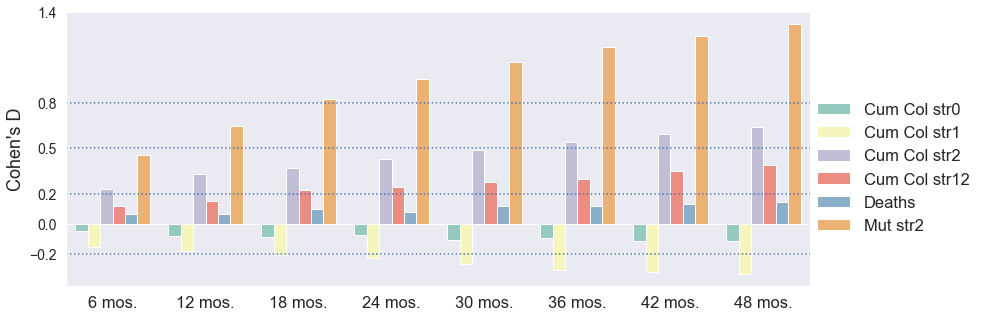

In [163]:
fig=plt.figure(figsize=(5,15))
sns.set(font_scale = 1.5)
ax = sns.catplot(x='time', y="Cohen's D", hue=' ', data=dff1, kind='bar', height=5, aspect=2.4, palette = 'Set3')
plt.axhline(0.2, ls='dotted')
plt.axhline(0.5, ls='dotted')
plt.axhline(0.8, ls='dotted')
plt.axhline(-0.2, ls='dotted')
plt.yticks([-0.2,0,0.2,0.5,0.8,1.4], fontsize=14)
ax.set(xlabel=None)
plt.show()

<Figure size 360x1080 with 0 Axes>

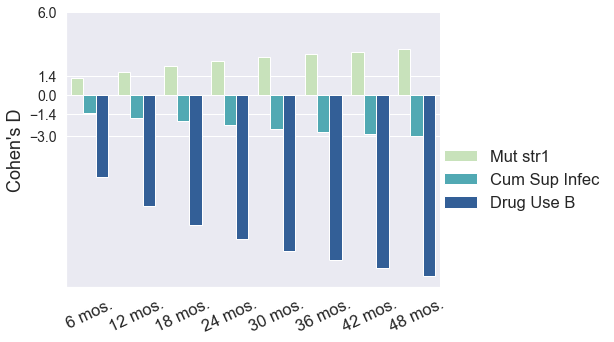

In [43]:
fig=plt.figure(figsize=(5,15))
sns.set(font_scale = 1.5)
ax = sns.catplot(x='time', y="Cohen's D", hue=' ', data=dff2, kind='bar', height=5, aspect=1.4, palette = 'YlGnBu')
plt.yticks([-3,-1.4,0,1.4,6], fontsize=14)
ax.set(xlabel=None)
plt.xticks(rotation=25)
plt.show()

In [206]:
print(min(df10['Cum Col str1']),
min(df11['Cum Col str2']),
min(df12['Cum Col str12']),
min(df13['Deaths']),
min(df14['Mut str1']),
max(df15['Mut str2']),
min(df16['Cum Sup Infec']))

-0.007 0.035 0.008 0.011 0.032 0.076 0.221


In [207]:
threshold = []
for j in range (0,8):
    tlist=[]
    for i in range (0,208):
        if abs(dic_metrics2[file_name][j][i])>0.2:
            tlist.append(i+1)
            break
    for i in range (0,208):
        if abs(dic_metrics2[file_name][j][i])>0.5:
            tlist.append(i+1)
            break
    for i in range (0,208):
        if abs(dic_metrics2[file_name][j][i])>0.8:
            tlist.append(i+1)
            break
    for i in range (0,208):
        if abs(dic_metrics2[file_name][j][i])>1.4:
            tlist.append(i+1)
            break
    threshold.append(tlist)
threshold

[[3, 21, 65, 206],
 [4, 12, 23, 62],
 [2, 11, 24, 66],
 [2, 57],
 [2, 33, 77],
 [1, 1, 1, 1],
 [9, 27, 56, 144],
 [1, 37, 108]]

In [208]:
threshold1 = []
for j in [11,12,13,14,0,25,26,10]:
    tlist=[]
    for i in range (0,208):
        if abs(dic_metrics1[file_name][j][i])>0.2:
            tlist.append(i+1)
            break
    for i in range (0,208):
        if abs(dic_metrics1[file_name][j][i])>0.5:
            tlist.append(i+1)
            break
    for i in range (0,208):
        if abs(dic_metrics1[file_name][j][i])>0.8:
            tlist.append(i+1)
            break
    for i in range (0,208):
        if abs(dic_metrics1[file_name][j][i])>1.4:
            tlist.append(i+1)
            break
    threshold1.append(tlist)
threshold1

[[21, 153], [76], [22, 90], [57], [198], [19, 104], [], [1, 105]]

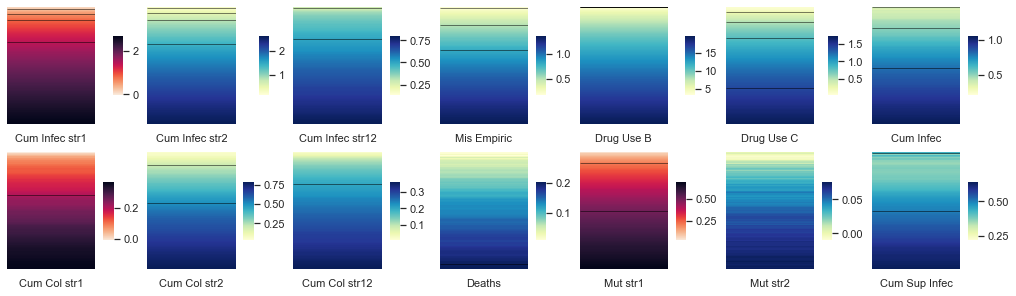

In [209]:
cbar_kws = {"shrink": 0.5}

fig, axs = plt.subplots(2,7,gridspec_kw={'hspace': 0.1, 'wspace': 0.1},constrained_layout=True,figsize=(14, 4))

#sns.heatmap(df1, yticklabels=207, ax=axs[0,0], cbar_kws=cbar_kws, cmap=sns.cm.rocket_r)
sns.heatmap(df2, yticklabels=False, ax=axs[0,0], cbar_kws=cbar_kws, cmap=sns.cm.rocket_r)
sns.heatmap(df3, yticklabels=False, ax=axs[0,1], cmap="YlGnBu", cbar_kws=cbar_kws)
sns.heatmap(df4, yticklabels=False, ax=axs[0,2],cmap="YlGnBu", cbar_kws=cbar_kws)
sns.heatmap(df5, yticklabels=False, ax=axs[0,3],cmap="YlGnBu", cbar_kws=cbar_kws)
sns.heatmap(df6, yticklabels=False, ax=axs[0,4],cmap="YlGnBu", cbar_kws=cbar_kws)
sns.heatmap(df7, yticklabels=False, ax=axs[0,5],cmap="YlGnBu", cbar_kws=cbar_kws)
sns.heatmap(df8, yticklabels=False, ax=axs[0,6],cmap="YlGnBu", cbar_kws=cbar_kws)

#sns.heatmap(df9, yticklabels=207, ax=axs[1,0], cmap="YlGnBu", cbar_kws=cbar_kws)
sns.heatmap(df10, yticklabels=False, ax=axs[1,0], cbar_kws=cbar_kws, cmap=sns.cm.rocket_r)
sns.heatmap(df11, yticklabels=False, ax=axs[1,1], cmap="YlGnBu", cbar_kws=cbar_kws)
sns.heatmap(df12, yticklabels=False, ax=axs[1,2],cmap="YlGnBu", cbar_kws=cbar_kws)
sns.heatmap(df13, yticklabels=False, ax=axs[1,3],cmap="YlGnBu", cbar_kws=cbar_kws)
sns.heatmap(df14, yticklabels=False, ax=axs[1,4], cbar_kws=cbar_kws, cmap=sns.cm.rocket_r)
sns.heatmap(df15, yticklabels=False, ax=axs[1,5], cmap="YlGnBu", cbar_kws=cbar_kws)
sns.heatmap(df16, yticklabels=False, ax=axs[1,6],cmap="YlGnBu", cbar_kws=cbar_kws)
for i in range (0,7):
    axs[0,i].hlines(threshold[i+1], *axs[0,i].get_xlim(), linewidths=0.5, color='black')
for i in range (0,7):
    axs[1,i].hlines(threshold1[i+1], *axs[1,i].get_xlim(), linewidths=0.5, color='black')
plt.setp(axs[0,0].yaxis.get_majorticklabels(), rotation=0)
plt.setp(axs[1,0].yaxis.get_majorticklabels(), rotation=0)
plt.show()
fig.savefig('q25pr10_sensitivity.png',dpi=300,bbox_inches = "tight")